# Fourier Ptychography Imaging
![](https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fnphoton.2013.187/MediaObjects/41566_2013_Article_BFnphoton2013187_Fig1_HTML.jpg)

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray
from IPython.display import display, clear_output

# To ensure plots are displayed inline in the notebook
%matplotlib inline

In [46]:
# =========================================================================
# Section 1: System Constants and Parameters (Unit: Micron)
# =========================================================================
initial_px = 0.275
upsample = 1

try:
    intensity_image_raw = imread('../assets/USAF_Resolution_Chart_A1-780.jpg')
    phase_image_raw = imread('../assets/cameraman.tif')
except Exception as e:
    print(f"Could not download image, using a fallback. Error: {e}")
    intensity_image_raw = np.random.rand(512, 512)

intensity_image = resize(rgb2gray(intensity_image_raw), (780 * upsample, 780 * upsample), anti_aliasing=True)
phase_image = resize(phase_image_raw, (780 * upsample, 780 * upsample), anti_aliasing=True)
#phase_image = intensity_image.copy()

wavelength = 0.632
wave_number = 2 * np.pi / wavelength
LED_spacing = 4000
illumination_distance = 80000
illumination_layers = 4
sampled_px = 2.75
NA = 0.08
add_noise = False
photon_conversion_factor = 5000
read_noise_variance = 1e-4
HR_dim = intensity_image.shape[0]
k_space_step = 1 / (HR_dim * initial_px)
pupil_radius_k = NA / wavelength
pupil_radius = int(np.round(pupil_radius_k / k_space_step))

In [47]:
# =========================================================================
# Section 2: Helper Functions
# =========================================================================
def illuminate(object_field, x_led, y_led, object_x_coords, object_y_coords, illumination_distance, wave_number):
    wavevector_denominator = np.sqrt(x_led**2 + y_led**2 + illumination_distance**2)
    kx = wave_number * x_led / wavevector_denominator
    ky = wave_number * y_led / wavevector_denominator
    illumination_wave = np.exp(1j * (object_x_coords * kx + object_y_coords * ky))
    illuminated_object = object_field * illumination_wave
    return illuminated_object, illumination_wave, kx, ky

def maskk(center_x_offset, center_y_offset, radius, height, width):
    center_y = height // 2 + center_y_offset
    center_x = width // 2 + center_x_offset
    y_coords, x_coords = np.ogrid[-center_y:height-center_y, -center_x:width-center_x]
    mask = x_coords**2 + y_coords**2 <= radius**2
    return mask

def imageit(illuminated_object, initial_px, sampled_px, pupil_radius):
    ft = np.fft.fftshift(np.fft.fft2(illuminated_object))
    lpf_mask = maskk(0, 0, pupil_radius, ft.shape[0], ft.shape[1])
    lpf_ft = np.zeros_like(ft)
    lpf_ft[lpf_mask] = ft[lpf_mask]
    lpf_image = np.fft.ifft2(np.fft.ifftshift(lpf_ft))
    
    downsample_ratio = initial_px / sampled_px
    output_shape = (int(np.round(lpf_image.shape[0] * downsample_ratio)),
                    int(np.round(lpf_image.shape[1] * downsample_ratio)))
    
    # Separate the complex field into real and imaginary parts
    real_part = np.real(lpf_image)
    imag_part = np.imag(lpf_image)
    
    # Resize each part individually
    resized_real = resize(real_part, output_shape, anti_aliasing=True)
    resized_imag = resize(imag_part, output_shape, anti_aliasing=True)
    
    # Recombine them into a complex field
    imaged_image = resized_real + 1j * resized_imag

    return imaged_image

--> Starting FPM simulation to generate data...
--> Simulation finished.



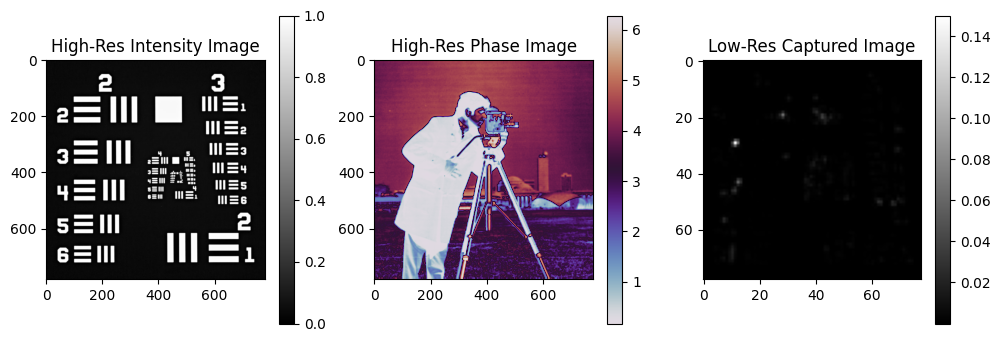

In [48]:
# =========================================================================
# Section 3: Object Generation & Simulation Loop
# =========================================================================
object_span = HR_dim * initial_px
x_vec = np.linspace(-object_span/2, object_span/2, HR_dim)
y_vec = np.linspace(-object_span/2, object_span/2, HR_dim)
object_x, object_y = np.meshgrid(y_vec, x_vec)

phase_image = (2*np.pi / np.max(phase_image)) * phase_image
object_field = intensity_image * np.exp(1j * phase_image)

N = 2 * illumination_layers - 1
num_images = N**2
LR_dim = int(np.round(HR_dim * (initial_px / sampled_px)))

imaged_images = np.zeros((LR_dim, LR_dim, num_images))
illumination_waves = np.zeros((HR_dim, HR_dim, num_images), dtype=np.complex128)
illumination_k_vectors = np.zeros((num_images, 2))

print('--> Starting FPM simulation to generate data...')
if add_noise: print('    NOTE: Noise simulation is ON.')

img_counter = 0
for a in range(N): # Corresponds to columns
    for b in range(N): # Corresponds to rows
        x_led = (a - (illumination_layers - 1)) * LED_spacing
        y_led = (b - (illumination_layers - 1)) * LED_spacing
        
        illuminated_object, illum_wave, kx, ky = illuminate(object_field, x_led, y_led, object_x, object_y, illumination_distance, wave_number)
        illumination_waves[:, :, img_counter] = illum_wave
        illumination_k_vectors[img_counter, :] = [kx, ky]
        
        imaged_image_field = imageit(illuminated_object, initial_px, sampled_px, pupil_radius)
        imaged_intensity = np.abs(imaged_image_field)**2
        
        if add_noise:
            mean_photon_counts = imaged_intensity * photon_conversion_factor
            noisy_photon_counts = np.random.poisson(mean_photon_counts)
            intensity_with_shot_noise = noisy_photon_counts / photon_conversion_factor
            read_noise = np.sqrt(read_noise_variance) * np.random.randn(*imaged_intensity.shape)
            imaged_intensity_noisy = intensity_with_shot_noise + read_noise
            imaged_intensity_noisy[imaged_intensity_noisy < 0] = 0
            imaged_images[:, :, img_counter] = imaged_intensity_noisy
        else:
            imaged_images[:, :, img_counter] = imaged_intensity
            
        img_counter += 1
print('--> Simulation finished.\n')

plt.figure(figsize=(12, 4))

plt.subplot(1,3,1)
plt.imshow(intensity_image, cmap='gray')
plt.title('High-Res Intensity Image')
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(phase_image, cmap='twilight')
plt.title('High-Res Phase Image')
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(imaged_intensity, cmap='gray')
plt.title('Low-Res Captured Image')
plt.colorbar()
plt.show()

In [49]:
# =========================================================================
# Section 4: Define Serpentine Scan Order for Reconstruction
# =========================================================================
print('--> Starting FPM reconstruction with SERPENTINE scan order...')

# --- Algorithm Parameters ---
num_iterations = 5
gamma = 1
plot_update_frequency = 5

# --- Initialization ---
center_led_idx = num_images // 2
object_recon = resize(np.sqrt(imaged_images[:, :, center_led_idx]), (HR_dim, HR_dim), anti_aliasing=True)
pupil_mask = maskk(0, 0, pupil_radius, HR_dim, HR_dim)

# --- Generate Serpentine Scan Orders ---
row_serpentine_order = np.zeros(N*N, dtype=int)
idx = 0
for r in range(N):
    if (r % 2) == 0:
        for c in range(N):
            row_serpentine_order[idx] = c * N + r
            idx += 1
    else:
        for c in range(N - 1, -1, -1):
            row_serpentine_order[idx] = c * N + r
            idx += 1

col_serpentine_order = np.zeros(N*N, dtype=int)
idx = 0
for c in range(N):
    if (c % 2) == 0:
        for r in range(N):
            col_serpentine_order[idx] = c * N + r
            idx += 1
    else:
        for r in range(N - 1, -1, -1):
            col_serpentine_order[idx] = c * N + r
            idx += 1

--> Starting FPM reconstruction with SERPENTINE scan order...


1. [Original Alternating-Projection Update](https://www.nature.com/articles/nphoton.2013.187):

$$
\Phi_n^{\prime}(r)=\sqrt{I_{U_n}(r)}\frac{\Phi_n(r)}{\left|\Phi_n(r)\right|},
$$

where $U_n$ is the illumination wavevector, $\phi_n$ is the exit wave at pupil plane and $P_n$ is the pupil function. 

The exit wave at the pupil plane while the sample is illuminated by wavevector $U_n$ can be simulated by the multiplication: $ \phi_n(u)=P_n(u)S_n(u-U_n)$, and the simulated image on the detector is the inverse Fourier transform of it: $\Phi_{n}(r)=\mathcal{F}^{-1}\{\phi_{n}(u)\}$.

It means that the modulus of the simulated image is replaced by the square-root of the real intensity measurement.



2. [HIO-like Alternating-Projection Update](https://doi.org/10.1364/OE.22.004960):

$$
S_{n+1}(u)=S_n(u)+\alpha\frac{P_n^*(u+U_n)}{\left|P_n(u+U_n)\right|_{\max}^2}\underbrace{[\phi_n^{\prime}(u+U_n)-\phi_n(u+U_n)]}_{\text{error in k-space}},
$$

the core of this formula is to calculate the error in the Fourier domain and update the spectrum.

3. Gradient-Descent Update (applied below)

$$
O_{n+1}(x) = O_n(x) + \gamma \cdot U_n^*(x) \cdot \left( \mathcal{F}^{-1} \left\{ P(k) \cdot \mathcal{F} \left\{ \mathcal{U} \left\{\underbrace{[ \sqrt{I_n} \frac{\mathcal{A}_n(O_n)}{|\mathcal{A}_n(O_n)|} - \mathcal{A}_n(O_n) ]}_{\text{error in r-space}}\right\} \right\} \right\} \right),
$$
where the Forward Operator $\mathcal{A}_n(O_n)$ represents the whole forward simulation process:
$$
\mathcal{A}_n(O_n) = \mathcal{D} \left\{ \mathcal{F}^{-1} \left\{ P(k) \cdot \mathcal{F} \left\{ O_n(x) \cdot U_n(x) \right\} \right\} \right\}.
$$

Simply put, the updating process is to propagate the error in the low-resolution spatial domain along the back propagation of the physical model, and then correct the estimated value of the previous iteration in the high-resolution spatial domain.

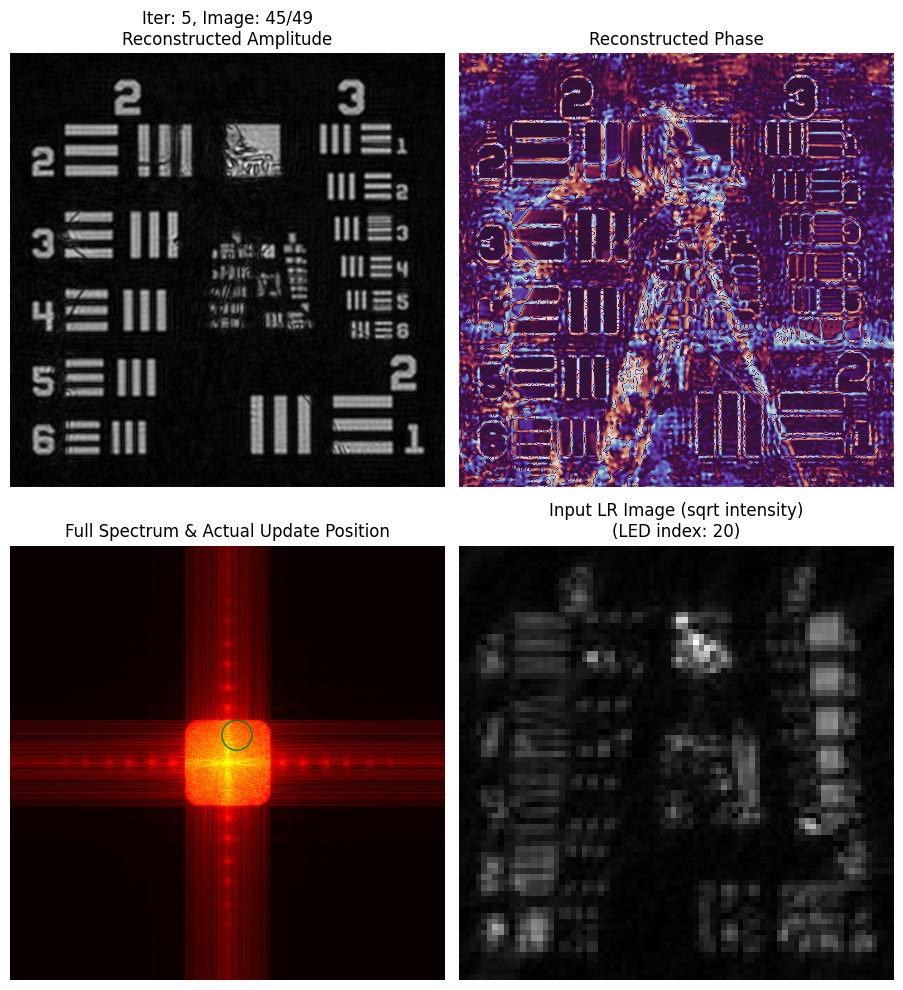

In [50]:
# =========================================================================
# Section 5: FPM reconstruction by Alternating Projection and Gradient Descent
# =========================================================================

# --- Create the visualization figure BEFORE the loop ---
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# --- Main Iteration Loop ---
for iter_num in range(num_iterations):
    if (iter_num + 1) % 2 == 1:
        update_order = row_serpentine_order
        print(f'  Iteration {iter_num + 1} of {num_iterations} (Row-wise Serpentine Scan)...')
    else:
        update_order = col_serpentine_order
        print(f'  Iteration {iter_num + 1} of {num_iterations} (Column-wise Serpentine Scan)...')
    
    for i, img_idx in enumerate(update_order):
        I_low_res = imaged_images[:, :, img_idx]
        illum_wave = illumination_waves[:, :, img_idx]
        
        illuminated_object_estimate = object_recon * illum_wave
        F_estimate = np.fft.fftshift(np.fft.fft2(illuminated_object_estimate))
        F_filtered = F_estimate * pupil_mask
        lpf_image_estimate = np.fft.ifft2(np.fft.ifftshift(F_filtered))
        
        # Resize the complex field by resizing its real and imaginary parts separately
        resized_real = resize(np.real(lpf_image_estimate), (LR_dim, LR_dim), anti_aliasing=True)
        resized_imag = resize(np.imag(lpf_image_estimate), (LR_dim, LR_dim), anti_aliasing=True)
        LR_field_estimate = resized_real + 1j * resized_imag
        
        updated_LR_field = np.sqrt(I_low_res) * np.exp(1j * np.angle(LR_field_estimate))

        error_LR = updated_LR_field - LR_field_estimate
        # Also apply the fix here when upsampling the complex error
        error_HR_real = resize(np.real(error_LR), (HR_dim, HR_dim), anti_aliasing=True)
        error_HR_imag = resize(np.imag(error_LR), (HR_dim, HR_dim), anti_aliasing=True)
        error_HR = error_HR_real + 1j * error_HR_imag
        
        F_error_HR = np.fft.fftshift(np.fft.fft2(error_HR))
        F_error_filtered = F_error_HR * pupil_mask
        error_term_for_update = np.fft.ifft2(np.fft.ifftshift(F_error_filtered))
        
        update_gradient = np.conj(illum_wave) * error_term_for_update

        object_recon_real =np.real(object_recon)+gamma*np.real(update_gradient)
        object_recon_imag =np.imag(object_recon)+gamma*np.imag(update_gradient)
        object_recon = object_recon_real +1j* object_recon_imag

        if (i + 1) % plot_update_frequency == 0:
            clear_output(wait=True)
            
            axes[0, 0].clear()
            axes[0, 0].imshow(np.abs(object_recon), cmap='gray')
            axes[0, 0].set_title(f'Iter: {iter_num+1}, Image: {i+1}/{num_images}\nReconstructed Amplitude')
            axes[0, 0].axis('off')
            
            axes[0, 1].clear()
            axes[0, 1].imshow(np.angle(object_recon), cmap='twilight')
            axes[0, 1].set_title('Reconstructed Phase')
            axes[0, 1].axis('off')

            axes[1, 0].clear()
            object_spectrum_recon = np.fft.fftshift(np.fft.fft2(object_recon))
            axes[1, 0].imshow(np.log(1 + np.abs(object_spectrum_recon)), cmap='hot')
            kx_now, ky_now = illumination_k_vectors[img_idx]
            k_shift_x_px = int(np.round((-kx_now / (2*np.pi)) / k_space_step))
            k_shift_y_px = int(np.round((-ky_now / (2*np.pi)) / k_space_step))
            pupil_center_x = HR_dim//2 + k_shift_x_px
            pupil_center_y = HR_dim//2 + k_shift_y_px
            circle = Circle((pupil_center_x, pupil_center_y), pupil_radius, color='g', fill=False, linewidth=1)
            axes[1, 0].add_patch(circle)
            axes[1, 0].set_title('Full Spectrum & Actual Update Position')
            axes[1, 0].axis('off')

            axes[1, 1].clear()
            axes[1, 1].imshow(np.sqrt(I_low_res), cmap='gray')
            axes[1, 1].set_title(f'Input LR Image (sqrt intensity)\n(LED index: {img_idx})')
            axes[1, 1].axis('off')
            
            plt.tight_layout()
            display(fig)

print('--> Reconstruction finished.')
clear_output()

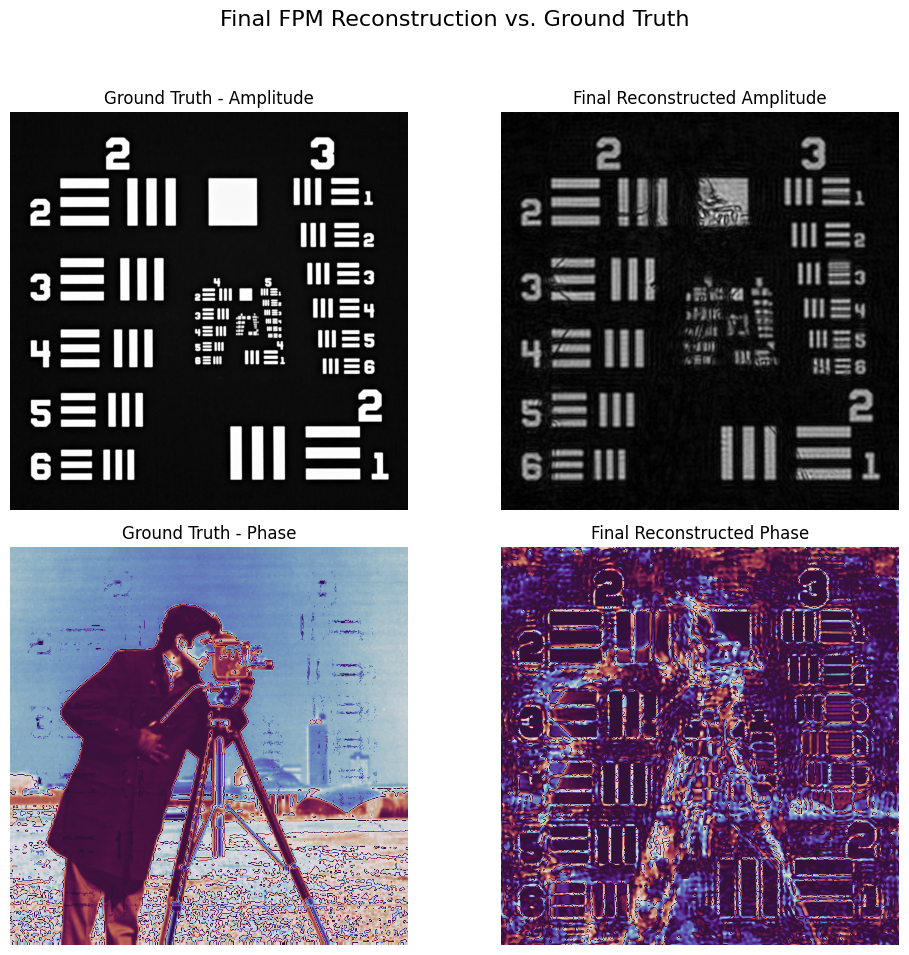

In [51]:
# =========================================================================
# Section 5: Display Final Reconstruction Results
# =========================================================================
fig_final, axes_final = plt.subplots(2, 2, figsize=(10, 10))
fig_final.suptitle('Final FPM Reconstruction vs. Ground Truth', fontsize=16)

axes_final[0, 0].imshow(np.abs(object_field), cmap='gray')
axes_final[0, 0].set_title('Ground Truth - Amplitude')
axes_final[0, 0].axis('off')

axes_final[1, 0].imshow(np.angle(object_field), cmap='twilight')
axes_final[1, 0].set_title('Ground Truth - Phase')
axes_final[1, 0].axis('off')

axes_final[0, 1].imshow(np.abs(object_recon), cmap='gray')
axes_final[0, 1].set_title('Final Reconstructed Amplitude')
axes_final[0, 1].axis('off')

axes_final[1, 1].imshow(np.angle(object_recon), cmap='twilight')
axes_final[1, 1].set_title('Final Reconstructed Phase')
axes_final[1, 1].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()